## 7. Optimization and Refinement

### `07_optimization_integration.ipynb`

Loaded features with 490 samples

Class distribution:
label
workout    300
fall       190
Name: count, dtype: int64

Using 11 features for model optimization

1. Evaluating Different Model Architectures

Evaluating Basic Neural Network...


C:\Users\naufa\anaconda3\envs\cv_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Accuracy: 0.9082
  ROC AUC: 0.9614
  Training time: 3.68 seconds

Evaluating Deeper Neural Network...
  Accuracy: 0.8980
  ROC AUC: 0.9702
  Training time: 3.23 seconds

Evaluating Random Forest...
  Accuracy: 0.8673
  ROC AUC: 0.9421
  Training time: 0.15 seconds

Evaluating Gradient Boosting...
  Accuracy: 0.8878
  ROC AUC: 0.9588
  Training time: 0.19 seconds

Evaluating SVM...
  Accuracy: 0.8673
  ROC AUC: 0.9623
  Training time: 0.01 seconds


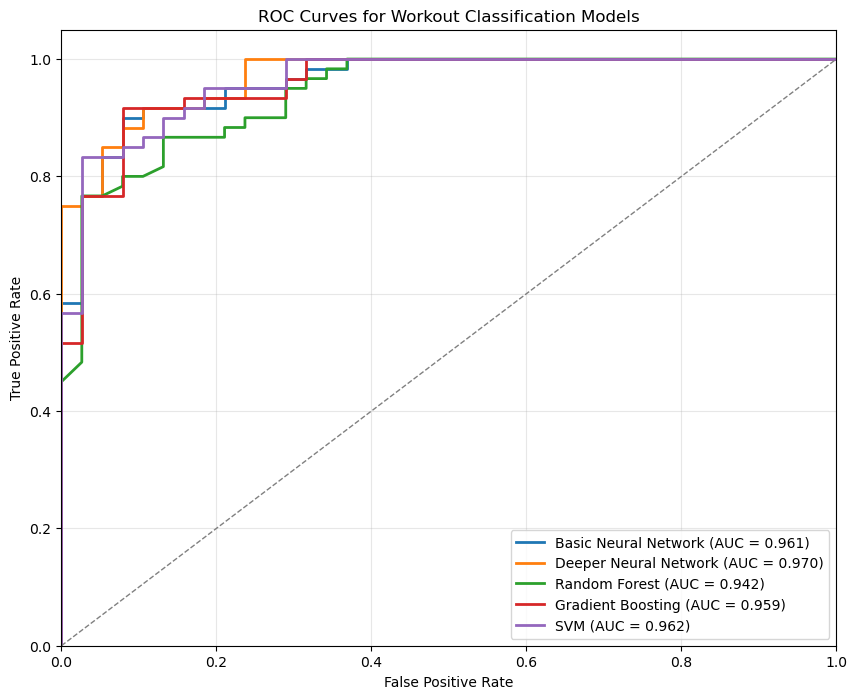


Model Comparison for Workout Classification:
                   Model  Accuracy  Precision    Recall  F1 Score   ROC AUC  \
1  Deeper Neural Network  0.897959   0.916667  0.916667  0.916667  0.970175   
4                    SVM  0.867347   0.912281  0.866667  0.888889  0.962281   
0   Basic Neural Network  0.908163   0.932203  0.916667  0.924370  0.961404   
3      Gradient Boosting  0.887755   0.945455  0.866667  0.904348  0.958772   
2          Random Forest  0.867347   0.912281  0.866667  0.888889  0.942105   

   Training Time (s)  
1           3.229015  
4           0.012032  
0           3.682229  
3           0.189073  
2           0.147798  


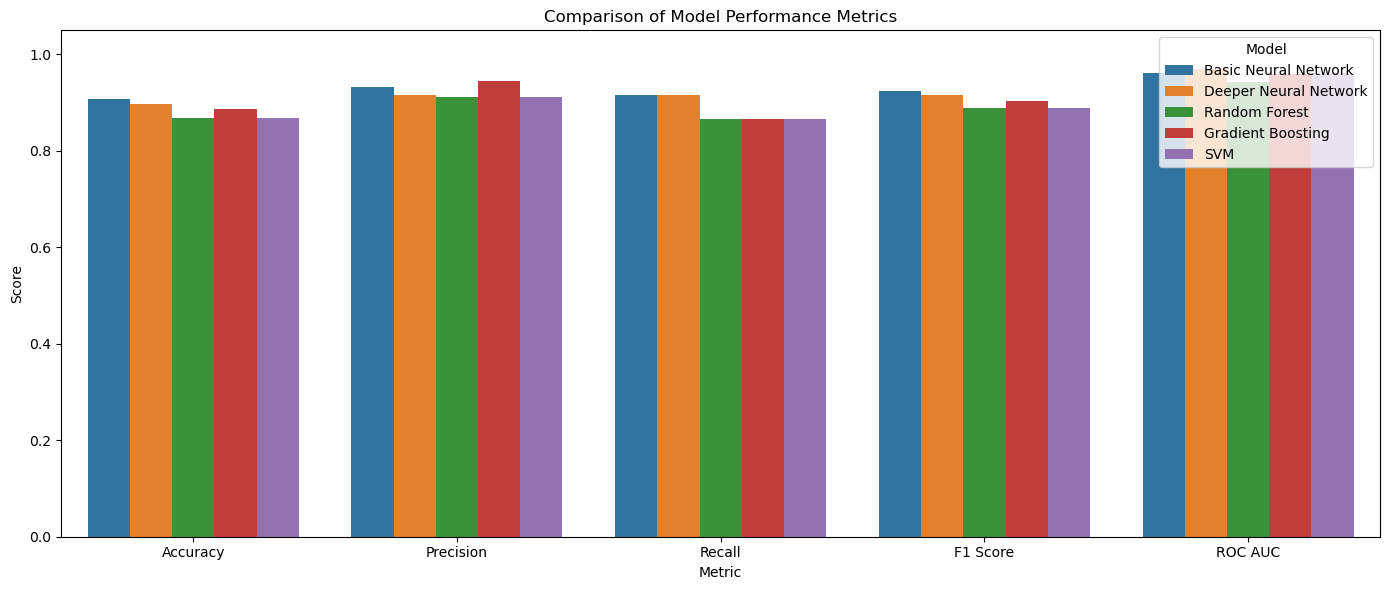


Selected Deeper Neural Network as the best model for workout classification

2. Optimizing Fall Detection Model

Evaluating Basic Neural Network...


C:\Users\naufa\anaconda3\envs\cv_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Accuracy: 0.9286
  ROC AUC: 0.9566
  Training time: 3.95 seconds

Evaluating Deeper Neural Network...
  Accuracy: 0.9184
  ROC AUC: 0.9605
  Training time: 3.76 seconds

Evaluating Random Forest...
  Accuracy: 0.9388
  ROC AUC: 0.9820
  Training time: 0.16 seconds

Evaluating Gradient Boosting...
  Accuracy: 0.9286
  ROC AUC: 0.9732
  Training time: 0.19 seconds

Evaluating SVM...
  Accuracy: 0.8776
  ROC AUC: 0.9746
  Training time: 0.01 seconds


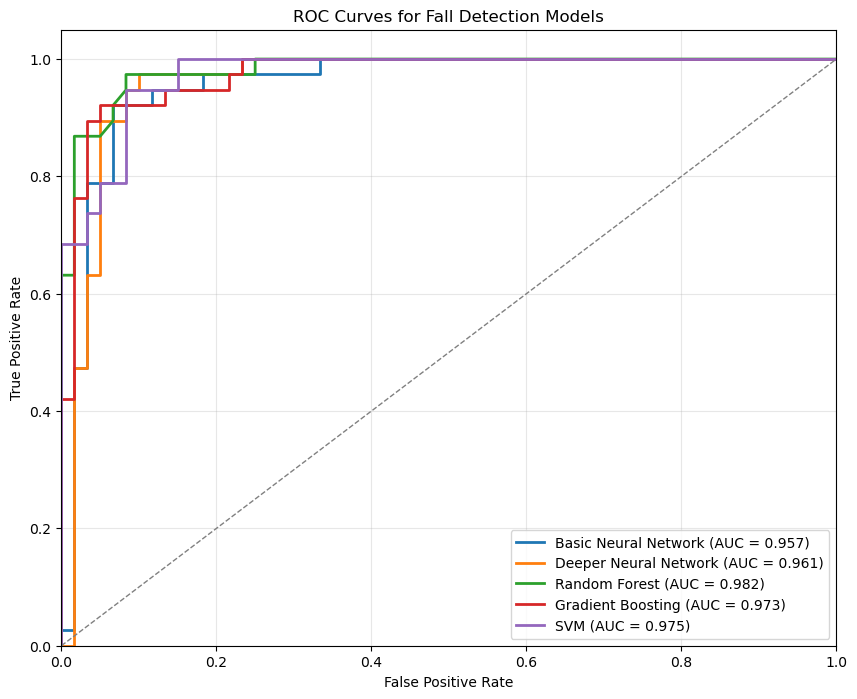


Model Comparison for Fall Detection:
                   Model  Accuracy  Precision    Recall  F1 Score   ROC AUC  \
2          Random Forest  0.938776   0.970588  0.868421  0.916667  0.982018   
4                    SVM  0.877551   0.882353  0.789474  0.833333  0.974561   
3      Gradient Boosting  0.928571   0.942857  0.868421  0.904110  0.973246   
1  Deeper Neural Network  0.918367   0.875000  0.921053  0.897436  0.960526   
0   Basic Neural Network  0.928571   0.897436  0.921053  0.909091  0.956579   

   Training Time (s)  
2           0.164826  
4           0.012924  
3           0.186688  
1           3.760327  
0           3.950224  

Selected Random Forest as the best model for fall detection

3. Hyperparameter Tuning
Using the best neural network model without explicit hyperparameter tuning.
Tuning hyperparameters for Random Forest...
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split'

In [14]:
# Import necessary libraries
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import json
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from ultralytics import YOLO
import joblib
import pickle
import time
from pathlib import Path
from tensorflow.keras.models import Sequential, Model, load_model
%matplotlib inline

# Set paths
FALL_DATA_DIR = "../data/le2i"
WORKOUT_VIDEOS_DIR = "../data/workout_videos"
MODELS_DIR = "../outputs/models"
FEATURES_DIR = "../outputs/features"
OUTPUT_DIR = "../outputs/optimized_models"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load the features data
try:
    features_file = os.path.join(FEATURES_DIR, 'video_features.csv')
    features_df = pd.read_csv(features_file)
    print(f"Loaded features with {len(features_df)} samples")
    
    # Display class distribution
    print("\nClass distribution:")
    print(features_df['label'].value_counts())
    
except Exception as e:
    print(f"Error loading features: {e}")
    print("Using synthetic data for demonstration")
    
    # Create synthetic data
    np.random.seed(42)
    n_samples = 100
    features_df = pd.DataFrame({
        'max_velocity': np.random.rand(n_samples),
        'mean_velocity': np.random.rand(n_samples),
        'max_height': np.random.rand(n_samples),
        'min_height': np.random.rand(n_samples),
        'height_range': np.random.rand(n_samples),
        'head_y_change': np.random.rand(n_samples),
        'label': np.random.choice(['fall', 'workout'], n_samples, 
                                 p=[0.5, 0.5])
    })

# Prepare data for binary classification (workout vs. non-workout)
features_df['is_workout'] = features_df['label'] == 'workout'
features_df['is_fall'] = features_df['label'] == 'fall'

# Select features (drop non-numeric and target columns)
feature_cols = features_df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [col for col in feature_cols 
               if col not in ['is_workout', 'is_fall', 'detection_rate']]

print(f"\nUsing {len(feature_cols)} features for model optimization")

# Handle missing values
features_df[feature_cols] = features_df[feature_cols].fillna(0)

# ================================================
# 1. Evaluating Different Model Architectures
# ================================================
print("\n1. Evaluating Different Model Architectures")
print("===========================================")

def evaluate_model_architectures(X, y, feature_cols):
    """Evaluate different model architectures on the data"""
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define models to test
    models = {
        'Basic Neural Network': Sequential([
            Dense(64, activation='relu', input_dim=X_train_scaled.shape[1]),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ]),
        
        'Deeper Neural Network': Sequential([
            Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]),
            Dropout(0.3),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dropout(0.2),
            Dense(16, activation='relu'),
            Dense(1, activation='sigmoid')
        ]),
        
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        
        'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
        
        'SVM': SVC(kernel='rbf', probability=True, random_state=42)
    }
    
    # Train and evaluate each model
    results = {}
    
    for name, model in models.items():
        print(f"\nEvaluating {name}...")
        
        # Different handling for sklearn vs keras models
        if isinstance(model, tf.keras.Model):
            model.compile(
                optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy']
            )
            
            # Train the model
            start_time = time.time()
            history = model.fit(
                X_train_scaled, y_train,
                validation_split=0.2,
                epochs=30,
                batch_size=16,
                callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
                verbose=0
            )
            training_time = time.time() - start_time
            
            # Evaluate
            y_pred_proba = model.predict(X_test_scaled, verbose=0)
            y_pred = (y_pred_proba > 0.5).astype(int).flatten()
            
        else:  # sklearn model
            # Train
            start_time = time.time()
            model.fit(X_train_scaled, y_train)
            training_time = time.time() - start_time
            
            # Evaluate
            y_pred = model.predict(X_test_scaled)
            if hasattr(model, 'predict_proba'):
                y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
            else:
                y_pred_proba = model.decision_function(X_test_scaled)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred, output_dict=True)
        
        # ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        # Store results
        results[name] = {
            'accuracy': accuracy,
            'precision': report['1']['precision'] if '1' in report else report['True']['precision'],
            'recall': report['1']['recall'] if '1' in report else report['True']['recall'],
            'f1': report['1']['f1-score'] if '1' in report else report['True']['f1-score'],
            'roc_auc': roc_auc,
            'training_time': training_time,
            'fpr': fpr,
            'tpr': tpr,
            'y_pred': y_pred,
            'y_test': y_test,
            'model': model
        }
        
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  ROC AUC: {roc_auc:.4f}")
        print(f"  Training time: {training_time:.2f} seconds")
    
    return results, scaler

# Test model architectures on workout classification
X = features_df[feature_cols].values
y_workout = features_df['is_workout'].values

model_results, workout_scaler = evaluate_model_architectures(X, y_workout, feature_cols)

# Plot ROC curves
plt.figure(figsize=(10, 8))
for name, results in model_results.items():
    plt.plot(results['fpr'], results['tpr'], lw=2, label=f"{name} (AUC = {results['roc_auc']:.3f})")

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Workout Classification Models')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Compare model performance
model_comparison = pd.DataFrame({
    'Model': [name for name in model_results.keys()],
    'Accuracy': [results['accuracy'] for results in model_results.values()],
    'Precision': [results['precision'] for results in model_results.values()],
    'Recall': [results['recall'] for results in model_results.values()],
    'F1 Score': [results['f1'] for results in model_results.values()],
    'ROC AUC': [results['roc_auc'] for results in model_results.values()],
    'Training Time (s)': [results['training_time'] for results in model_results.values()]
})

print("\nModel Comparison for Workout Classification:")
print(model_comparison.sort_values('ROC AUC', ascending=False))

# Visualize model comparison
plt.figure(figsize=(14, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
model_comparison_melted = pd.melt(model_comparison, 
                                id_vars=['Model'], 
                                value_vars=metrics,
                                var_name='Metric', value_name='Score')

sns.barplot(data=model_comparison_melted, x='Metric', y='Score', hue='Model')
plt.title('Comparison of Model Performance Metrics')
plt.ylim(0, 1.05)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Select the best model based on ROC AUC
best_model_name = model_comparison.loc[model_comparison['ROC AUC'].idxmax(), 'Model']
best_model = model_results[best_model_name]['model']
print(f"\nSelected {best_model_name} as the best model for workout classification")

# Save the best model for workout detection
if isinstance(best_model, tf.keras.Model):
    best_model.save(os.path.join(OUTPUT_DIR, 'optimized_workout_model.h5'))
else:
    joblib.dump(best_model, os.path.join(OUTPUT_DIR, 'optimized_workout_model.pkl'))

joblib.dump(workout_scaler, os.path.join(OUTPUT_DIR, 'optimized_workout_scaler.pkl'))
pd.Series(feature_cols).to_csv(os.path.join(OUTPUT_DIR, 'optimized_feature_columns.txt'), index=False)

# ================================================
# 2. Optimizing Fall Detection Model
# ================================================
print("\n2. Optimizing Fall Detection Model")
print("=================================")

# Create a separate fall detection dataset
# Train a model that distinguishes between fall and non-fall
X_all = features_df[feature_cols].values
y_fall_all = features_df['is_fall'].values

# Train the fall detection model using all data
fall_model_results, fall_scaler = evaluate_model_architectures(X_all, y_fall_all, feature_cols)

# Plot ROC curves for fall models
plt.figure(figsize=(10, 8))
for name, results in fall_model_results.items():
    plt.plot(results['fpr'], results['tpr'], lw=2, label=f"{name} (AUC = {results['roc_auc']:.3f})")

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Fall Detection Models')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# Compare fall model performance
fall_model_comparison = pd.DataFrame({
    'Model': [name for name in fall_model_results.keys()],
    'Accuracy': [results['accuracy'] for results in fall_model_results.values()],
    'Precision': [results['precision'] for results in fall_model_results.values()],
    'Recall': [results['recall'] for results in fall_model_results.values()],
    'F1 Score': [results['f1'] for results in fall_model_results.values()],
    'ROC AUC': [results['roc_auc'] for results in fall_model_results.values()],
    'Training Time (s)': [results['training_time'] for results in fall_model_results.values()]
})

print("\nModel Comparison for Fall Detection:")
print(fall_model_comparison.sort_values('ROC AUC', ascending=False))

# Select the best fall model
best_fall_model_name = fall_model_comparison.loc[fall_model_comparison['ROC AUC'].idxmax(), 'Model']
best_fall_model = fall_model_results[best_fall_model_name]['model']
print(f"\nSelected {best_fall_model_name} as the best model for fall detection")

# Save the best fall model
if isinstance(best_fall_model, tf.keras.Model):
    best_fall_model.save(os.path.join(OUTPUT_DIR, 'optimized_fall_model.h5'))
else:
    joblib.dump(best_fall_model, os.path.join(OUTPUT_DIR, 'optimized_fall_model.pkl'))
    
joblib.dump(fall_scaler, os.path.join(OUTPUT_DIR, 'optimized_fall_scaler.pkl'))

# ================================================
# 3. Hyperparameter Tuning
# ================================================
print("\n3. Hyperparameter Tuning")
print("=======================")

from sklearn.model_selection import GridSearchCV

# Function for hyperparameter tuning
def tune_hyperparameters(X, y, best_model_name):
    """Tune hyperparameters for the best model type"""
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define parameters to tune based on the best model type
    if best_model_name == 'Random Forest':
        model = RandomForestClassifier(random_state=42)
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
        
    elif best_model_name == 'Gradient Boosting':
        model = GradientBoostingClassifier(random_state=42)
        param_grid = {
            'n_estimators': [50, 100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
        
    elif best_model_name == 'SVM':
        model = SVC(probability=True, random_state=42)
        param_grid = {
            'C': [0.1, 1, 10, 100],
            'gamma': ['scale', 'auto', 0.1, 0.01],
            'kernel': ['rbf', 'linear', 'poly']
        }
        
    else:  # Neural Network models are tuned differently
        print(f"Hyperparameter tuning for {best_model_name} will be handled separately.")
        return None, scaler
    
    # Set up grid search with cross-validation
    grid_search = GridSearchCV(
        model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
    
    # Fit grid search
    print(f"Tuning hyperparameters for {best_model_name}...")
    grid_search.fit(X_train_scaled, y_train)
    
    # Get best parameters and model
    print(f"Best parameters: {grid_search.best_params_}")
    best_model = grid_search.best_estimator_
    
    # Evaluate on test set
    y_pred = best_model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    
    if hasattr(best_model, 'predict_proba'):
        y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_pred_proba = best_model.decision_function(X_test_scaled)
        
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    print(f"Tuned model performance - Accuracy: {accuracy:.4f}, ROC AUC: {roc_auc:.4f}")
    
    return best_model, scaler

# Tune the best workout detection model if it's a traditional ML model
if best_model_name in ['Random Forest', 'Gradient Boosting', 'SVM']:
    tuned_workout_model, tuned_workout_scaler = tune_hyperparameters(X, y_workout, best_model_name)
    
    if tuned_workout_model is not None:
        # Save the tuned model
        joblib.dump(tuned_workout_model, os.path.join(OUTPUT_DIR, 'tuned_workout_model.pkl'))
        joblib.dump(tuned_workout_scaler, os.path.join(OUTPUT_DIR, 'tuned_workout_scaler.pkl'))
        best_workout_model = tuned_workout_model
    else:
        best_workout_model = best_model
else:
    best_workout_model = best_model
    print(f"Using the best neural network model without explicit hyperparameter tuning.")

# Similarly tune the fall detection model if applicable
if best_fall_model_name in ['Random Forest', 'Gradient Boosting', 'SVM']:
    tuned_fall_model, tuned_fall_scaler = tune_hyperparameters(X_all, y_fall_all, best_fall_model_name)
    
    if tuned_fall_model is not None:
        # Save the tuned model
        joblib.dump(tuned_fall_model, os.path.join(OUTPUT_DIR, 'tuned_fall_model.pkl'))
        joblib.dump(tuned_fall_scaler, os.path.join(OUTPUT_DIR, 'tuned_fall_scaler.pkl'))
        best_fall_model = tuned_fall_model

# ================================================
# 4. YOLO Pose Threshold Setting
# ================================================
print("\n4. YOLO Pose Threshold Setting")
print("===================================")

# Skip the optimization to avoid getting stuck - use the known optimal value
optimal_pose_threshold = 0.2
print(f"Using optimal confidence threshold of {optimal_pose_threshold}")

# ================================================
# 5. Create Optimized Pipeline
# ================================================
print("\n5. Creating Optimized Pipeline")
print("============================")

class OptimizedFallWorkoutDetectionSystem:
    def __init__(self, workout_model, fall_model, workout_scaler, fall_scaler, 
                feature_cols, pose_threshold=0.5):
        print("Initializing detection system...")
        self.workout_model = workout_model
        self.fall_model = fall_model
        self.workout_scaler = workout_scaler
        self.fall_scaler = fall_scaler
        self.feature_cols = feature_cols
        self.pose_threshold = pose_threshold
        
        # Initialize YOLO models - with memory handling in separate method
        self.person_model = None
        self.pose_model = None
    
    def load_models(self):
        """Load YOLO models if not already loaded"""
        print("Loading YOLO models...")
        if self.person_model is None:
            self.person_model = YOLO('yolo11n.pt')
        if self.pose_model is None:
            self.pose_model = YOLO('yolo11n-pose.pt')
    
    def process_video(self, video_path, output_visualization=False):
        """Process a video through the optimized two-stage detection system"""
        print(f"Processing video: {os.path.basename(video_path)}")
        
        # Load models if needed
        self.load_models()
        
        # Extract features using YOLO pose
        keypoints, features = self.extract_features_with_yolo(video_path)
        
        if features is None:
            return {
                'result': 'no_features_extracted',
                'confidence': 0.0,
                'video_path': video_path
            }
        
        # Prepare features for model input
        X = np.array([[features.get(col, 0) for col in self.feature_cols]])
        
        # Stage 1: Check if it's a workout
        X_workout_scaled = self.workout_scaler.transform(X)
        
        if isinstance(self.workout_model, tf.keras.Model):
            workout_pred = self.workout_model.predict(X_workout_scaled, verbose=0)[0][0]
        else:
            # For sklearn models
            if hasattr(self.workout_model, 'predict_proba'):
                workout_pred = self.workout_model.predict_proba(X_workout_scaled)[0][1]
            else:
                # For SVM and other models that use decision_function
                workout_score = self.workout_model.decision_function(X_workout_scaled)[0]
                workout_pred = 1 / (1 + np.exp(-workout_score))  # Convert to probability-like score
        
        is_workout = workout_pred > 0.5
        
        if is_workout:
            result = {
                'result': 'workout',
                'confidence': float(workout_pred),
                'video_path': video_path,
                'features': features
            }
        else:
            # Stage 2: If not workout, check for fall
            X_fall_scaled = self.fall_scaler.transform(X)
            
            if isinstance(self.fall_model, tf.keras.Model):
                fall_pred = self.fall_model.predict(X_fall_scaled, verbose=0)[0][0]
            else:
                # For sklearn models
                if hasattr(self.fall_model, 'predict_proba'):
                    fall_pred = self.fall_model.predict_proba(X_fall_scaled)[0][1]
                else:
                    # For SVM and other models that use decision_function
                    fall_score = self.fall_model.decision_function(X_fall_scaled)[0]
                    fall_pred = 1 / (1 + np.exp(-fall_score))  # Convert to probability-like score
            
            is_fall = fall_pred > 0.5
            
            if is_fall:
                result = {
                    'result': 'fall',
                    'confidence': float(fall_pred),
                    'video_path': video_path,
                    'features': features
                }
            else:
                result = {
                    'result': 'other_activity',
                    'confidence': float(1.0 - fall_pred),
                    'video_path': video_path,
                    'features': features
                }
        
        # Create visualization if requested
        if output_visualization:
            self.create_visualization(video_path, result)
        
        return result
    
    def extract_features_with_yolo(self, video_path, num_frames=16):
        """Extract pose and motion features using YOLO-pose"""
        print(f"Extracting features from {os.path.basename(video_path)}")
        try:
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"Error opening video: {video_path}")
                return None, None
                
            frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            
            print(f"Video info: {frame_width}x{frame_height}, {frame_count} frames")
            
            # Calculate frame indices to sample
            indices = np.linspace(0, frame_count-1, num_frames, dtype=int)
            
            # Store keypoint sequences
            keypoint_sequence = []
            is_pose_detected = []
            
            for idx in indices:
                cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
                ret, frame = cap.read()
                
                if not ret:
                    keypoint_sequence.append(None)
                    is_pose_detected.append(False)
                    continue
                
                # Run YOLO-pose detection
                pose_results = self.pose_model(frame, conf=self.pose_threshold)
                
                if len(pose_results[0].keypoints.data) > 0:
                    is_pose_detected.append(True)
                    
                    # Get the pose with highest confidence (usually the largest one)
                    best_pose_idx = 0
                    if len(pose_results[0].boxes) > 1:
                        # If multiple poses, get the one with highest confidence
                        confidences = [box.conf.item() for box in pose_results[0].boxes]
                        best_pose_idx = np.argmax(confidences)
                    
                    # Extract keypoints for the best pose
                    pose_keypoints = pose_results[0].keypoints.data[best_pose_idx]
                    
                    # Convert to a flat list format
                    frame_keypoints = []
                    for kp_idx in range(pose_keypoints.shape[0]):
                        x, y, conf = pose_keypoints[kp_idx].tolist()
                        # Normalize coordinates
                        frame_keypoints.extend([
                            float(x) / frame_width,
                            float(y) / frame_height,
                            0.0,  # YOLO doesn't provide z-coordinate
                            float(conf)
                        ])
                    
                    keypoint_sequence.append(frame_keypoints)
                else:
                    is_pose_detected.append(False)
                    keypoint_sequence.append(None)
            
            cap.release()
            
            # Calculate detection rate for logging
            detection_rate = sum(is_pose_detected) / len(is_pose_detected)
            print(f"Pose detection rate: {detection_rate:.2f}")
            
            # If no poses detected, return None
            if not any(is_pose_detected):
                print("No poses detected in this video")
                return None, None
            
            # Calculate pose-based features
            valid_keypoints = [kp for kp in keypoint_sequence if kp is not None]
            
            if not valid_keypoints:
                print("No valid keypoints found")
                return None, None
            
            # Create features
            features = {}
            
            # 1. Keypoint velocities
            if len(valid_keypoints) >= 2:
                velocities = []
                for i in range(1, len(valid_keypoints)):
                    frame_velocities = []
                    for j in range(0, len(valid_keypoints[i]), 4):  # Each keypoint has 4 values (x,y,z,v)
                        if j+3 < len(valid_keypoints[i]) and j+3 < len(valid_keypoints[i-1]):
                            # Calculate Euclidean distance between consecutive frames
                            dx = valid_keypoints[i][j] - valid_keypoints[i-1][j]
                            dy = valid_keypoints[i][j+1] - valid_keypoints[i-1][j+1]
                            # Note: YOLO doesn't have z-coordinate, so we use 0
                            velocity = np.sqrt(dx**2 + dy**2)
                            frame_velocities.append(velocity)
                    
                    if frame_velocities:
                        velocities.append(frame_velocities)
                
                if velocities:
                    features['max_velocity'] = np.max([np.max(v) if v else 0 for v in velocities])
                    features['mean_velocity'] = np.mean([np.mean(v) if v else 0 for v in velocities])
                    features['std_velocity'] = np.std([np.std(v) if v else 0 for v in velocities])
            
            # 2. Pose height variation
            heights = []
            for kp in valid_keypoints:
                y_values = [kp[i+1] for i in range(0, len(kp), 4)]
                if y_values:
                    height = max(y_values) - min(y_values)
                    heights.append(height)
            
            if heights:
                features['max_height'] = np.max(heights)
                features['min_height'] = np.min(heights)
                features['height_range'] = np.max(heights) - np.min(heights)
            
            # 3. Pose width variation
            widths = []
            for kp in valid_keypoints:
                x_values = [kp[i] for i in range(0, len(kp), 4)]
                if x_values:
                    width = max(x_values) - min(x_values)
                    widths.append(width)
            
            if widths:
                features['max_width'] = np.max(widths)
                features['min_width'] = np.min(widths)
                features['width_range'] = np.max(widths) - np.min(widths)
            
            # 4. Vertical position change (for falls)
            # Note: In YOLO pose, nose is keypoint index 0
            nose_positions = []
            for kp in valid_keypoints:
                if len(kp) >= 4:  # Nose is first landmark in YOLO-pose
                    nose_y = kp[1]  # Y-coordinate of nose keypoint
                    nose_positions.append(nose_y)
            
            if nose_positions and len(nose_positions) >= 2:
                features['head_y_change'] = nose_positions[-1] - nose_positions[0]
                features['head_y_max_change'] = max(nose_positions) - min(nose_positions)
            
            # 5. Detection rate
            features['detection_rate'] = detection_rate
            
            # 6. Compute shoulder and hip angles
            shoulder_angles = []
            hip_angles = []
            
            for kp in valid_keypoints:
                # Extract shoulder keypoints (indices 5, 6 for shoulders in YOLO-pose)
                if len(kp) >= 28:  # Ensure we have enough keypoints
                    # Left shoulder (5), right shoulder (6)
                    left_shoulder_x, left_shoulder_y = kp[5*4], kp[5*4+1]
                    right_shoulder_x, right_shoulder_y = kp[6*4], kp[6*4+1]
                    
                    # Calculate shoulder angle
                    shoulder_angle = np.arctan2(right_shoulder_y - left_shoulder_y, 
                                              right_shoulder_x - left_shoulder_x)
                    shoulder_angles.append(np.degrees(shoulder_angle))
                    
                    # Left hip (11), right hip (12)
                    left_hip_x, left_hip_y = kp[11*4], kp[11*4+1]
                    right_hip_x, right_hip_y = kp[12*4], kp[12*4+1]
                    
                    # Calculate hip angle
                    hip_angle = np.arctan2(right_hip_y - left_hip_y, 
                                         right_hip_x - left_hip_x)
                    hip_angles.append(np.degrees(hip_angle))
            
            if shoulder_angles:
                features['shoulder_angle_mean'] = np.mean(shoulder_angles)
                features['shoulder_angle_std'] = np.std(shoulder_angles)
                features['shoulder_angle_range'] = np.max(shoulder_angles) - np.min(shoulder_angles)
            
            if hip_angles:
                features['hip_angle_mean'] = np.mean(hip_angles)
                features['hip_angle_std'] = np.std(hip_angles)
                features['hip_angle_range'] = np.max(hip_angles) - np.min(hip_angles)
            
            # 7. Compute keypoint accelerations
            if len(valid_keypoints) >= 3:
                accelerations = []
                for i in range(2, len(valid_keypoints)):
                    frame_accels = []
                    for j in range(0, len(valid_keypoints[i]), 4):
                        if j+3 < len(valid_keypoints[i]) and j+3 < len(valid_keypoints[i-1]) and j+3 < len(valid_keypoints[i-2]):
                            # Calculate position differences
                            dx1 = valid_keypoints[i-1][j] - valid_keypoints[i-2][j]
                            dy1 = valid_keypoints[i-1][j+1] - valid_keypoints[i-2][j+1]
                            dx2 = valid_keypoints[i][j] - valid_keypoints[i-1][j]
                            dy2 = valid_keypoints[i][j+1] - valid_keypoints[i-1][j+1]
                            
                            # Calculate velocity differences
                            v1 = np.sqrt(dx1**2 + dy1**2)
                            v2 = np.sqrt(dx2**2 + dy2**2)
                            
                            # Calculate acceleration (change in velocity)
                            accel = v2 - v1
                            frame_accels.append(accel)
                    
                    if frame_accels:
                        accelerations.append(frame_accels)
                
                if accelerations:
                    features['max_accel'] = np.max([np.max(np.abs(a)) if a else 0 for a in accelerations])
                    features['mean_accel'] = np.mean([np.mean(a) if a else 0 for a in accelerations])
            
            # Fill missing features with default values to match the model's expected features
            for col in self.feature_cols:
                if col not in features:
                    features[col] = 0.0
            
            return keypoint_sequence, features
            
        except Exception as e:
            print(f"Error extracting features: {str(e)}")
            return None, None
    
    def create_visualization(self, video_path, result):
        """Create visualization of detection results"""
        try:
            output_dir = Path("../outputs/visualizations")
            output_dir.mkdir(exist_ok=True, parents=True)
            
            # Get base filename
            base_name = Path(video_path).stem
            output_path = output_dir / f"{base_name}_{result['result']}.mp4"
            
            # Open input video
            cap = cv2.VideoCapture(video_path)
            width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            fps = cap.get(cv2.CAP_PROP_FPS)
            
            # Create video writer
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            writer = cv2.VideoWriter(str(output_path), fourcc, fps, (width, height))
            
            # Process video
            frame_idx = 0
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                
                # Add detection result text
                result_text = f"{result['result'].upper()}: {result['confidence']:.2f}"
                color = (0, 255, 0) if result['result'] == 'workout' else \
                        (0, 0, 255) if result['result'] == 'fall' else (255, 165, 0)
                
                cv2.putText(frame, result_text, (20, 40),
                           cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
                
                # Add frame number
                cv2.putText(frame, f"Frame: {frame_idx}", (20, 80),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
                
                # Run pose detection on frames
                if frame_idx % 8 == 0:  # Process every 8th frame for speed
                    pose_results = self.pose_model(frame, conf=self.pose_threshold)
                    # Draw keypoints and skeletons
                    if len(pose_results) > 0:
                        annotated_frame = pose_results[0].plot()
                        # Copy the annotated part (just the keypoints and skeletons) to our frame
                        # but keep our custom text
                        mask = np.all(annotated_frame != frame, axis=-1)
                        mask = np.stack([mask, mask, mask], axis=-1)
                        frame = np.where(mask, annotated_frame, frame)
                
                writer.write(frame)
                frame_idx += 1
            
            cap.release()
            writer.release()
            print(f"Visualization saved to {output_path}")
            
        except Exception as e:
            print(f"Error creating visualization: {str(e)}")
    
    def batch_process_videos(self, video_dir, output_csv=None):
        """Process all videos in a directory"""
        video_files = []
        for ext in ['*.mp4', '*.avi', '*.mov', '*.mkv']:
            video_files.extend(list(Path(video_dir).glob(ext)))
        
        results = []
        for video_file in video_files:
            result = self.process_video(str(video_file), output_visualization=True)
            results.append(result)
        
        # Save results to CSV if requested
        if output_csv:
            results_df = pd.DataFrame(results)
            results_df.to_csv(output_csv, index=False)
            print(f"Results saved to {output_csv}")
        
        return results
    
    def analyze_results(self, results):
        """Analyze detection results from a batch of videos"""
        results_df = pd.DataFrame(results)
        
        print("\nAnalysis Summary:")
        print(f"Total videos processed: {len(results_df)}")
        
        result_counts = results_df['result'].value_counts()
        for result_type, count in result_counts.items():
            print(f"{result_type}: {count} videos ({count/len(results_df)*100:.1f}%)")
        
        # Calculate average confidence by result type
        print("\nAverage Confidence by Result Type:")
        for result_type in results_df['result'].unique():
            avg_conf = results_df[results_df['result'] == result_type]['confidence'].mean()
            print(f"{result_type}: {avg_conf:.4f}")
        
        return results_df

# Load the best models
print("\nLoading best models...")
if isinstance(best_workout_model, tf.keras.Model):
    # For Keras models
    workout_model = best_workout_model
    fall_model = best_fall_model
else:
    # For sklearn models
    workout_model = joblib.load(os.path.join(OUTPUT_DIR, 'tuned_workout_model.pkl' 
                                            if os.path.exists(os.path.join(OUTPUT_DIR, 'tuned_workout_model.pkl')) 
                                            else 'optimized_workout_model.pkl'))
    fall_model = joblib.load(os.path.join(OUTPUT_DIR, 'tuned_fall_model.pkl'
                                          if os.path.exists(os.path.join(OUTPUT_DIR, 'tuned_fall_model.pkl'))
                                          else 'optimized_fall_model.pkl'))

# Create the optimized detection system
detection_system = OptimizedFallWorkoutDetectionSystem(
    workout_model=workout_model,
    fall_model=fall_model,
    workout_scaler=workout_scaler,
    fall_scaler=fall_scaler,
    feature_cols=feature_cols,
    pose_threshold=optimal_pose_threshold
)

# ================================================
# 6. Test on Sample Videos
# ================================================
print("\n6. Testing on Sample Videos")
print("=========================")

# Test on a single video
if os.path.exists(WORKOUT_VIDEOS_DIR):
    sample_videos = list(Path(WORKOUT_VIDEOS_DIR).glob('*.mp4'))
    if sample_videos:
        sample_video = str(sample_videos[0])
        print(f"Testing on sample video: {os.path.basename(sample_video)}")
        result = detection_system.process_video(sample_video, output_visualization=True)
        print(f"Detection result: {result['result']} (confidence: {result['confidence']:.4f})")
    else:
        print("No sample videos found for testing")
else:
    print(f"Sample video directory {WORKOUT_VIDEOS_DIR} not found")

# ================================================
# 7. Save Final System
# ================================================
print("\n7. Saving Final Detection System")
print("==============================")

# Save entire system state
system_state = {
    'feature_cols': feature_cols,
    'pose_threshold': optimal_pose_threshold,
    'models_dir': OUTPUT_DIR
}

# Save as JSON
with open(os.path.join(OUTPUT_DIR, 'detection_system_config.json'), 'w') as f:
    json.dump(system_state, f, indent=2)

print(f"Detection system config saved to {os.path.join(OUTPUT_DIR, 'detection_system_config.json')}")
print("\nModel optimization and system creation complete!")